In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno  as msno
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, mean_absolute_error

In [2]:
portogrande = pd.read_csv('../data/portogrande.txt')

# Tratando dados Faltantes

In [3]:
# tabela percentual de dados faltantes
def tabela_faltantes():
    features_numericas = ["hora","temp_ins", "temp_max", "temp_min", "umid_inst","umid_max","umid_min",
                          "pto_orvalho_inst", "pto_orvalho_max", "pto_orvalho_min","pressao","pressao_max",
                          "pressao_min","vento_vel", "vento_direcao", "vento_rajada", "radiacao","precipitacao"]

    df = portogrande[features_numericas]


    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)


    missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Dados Ausentes', '% Percentual'])
    missing_data.index.name =' Variaveis numericas'
    return missing_data

In [4]:
tabela_faltantes()

,Dados Ausentes,% Percentual
Variaveis numericas,,
vento_rajada,6,0.000813
pto_orvalho_max,5,0.000678
umid_min,5,0.000678
temp_max,5,0.000678
pressao_min,5,0.000678
pressao_max,5,0.000678
temp_min,5,0.000678
pto_orvalho_min,5,0.000678
umid_max,5,0.000678


In [5]:
# Preenchendo as colunas com o valor da média:
mean_vra = portogrande.vento_rajada.mean()
mean_orv_min = portogrande.pto_orvalho_min.mean()
mean_orv_max = portogrande.pto_orvalho_max.mean()
mean_umid_min = portogrande.umid_min.mean()
mean_umid_max = portogrande.umid_max.mean()
mean_temp_min = portogrande.temp_min.mean()
mean_temp_max = portogrande.temp_max.mean()
mean_pressao_min = portogrande.pressao_min.mean()
mean_pressao_max = portogrande.pressao_max.mean()

portogrande['vento_rajada'] = portogrande['vento_rajada'].fillna(mean_vra)
portogrande['pto_orvalho_min'] = portogrande['pto_orvalho_min'].fillna(mean_orv_min)
portogrande['pto_orvalho_max'] = portogrande['pto_orvalho_max'].fillna(mean_orv_max)
portogrande['umid_min'] = portogrande['umid_min'].fillna(mean_umid_min)
portogrande['umid_max'] = portogrande['umid_max'].fillna(mean_umid_max)
portogrande['temp_min'] = portogrande['temp_min'].fillna(mean_temp_min)
portogrande['temp_max'] = portogrande['temp_max'].fillna(mean_temp_max)
portogrande['pressao_min'] = portogrande['pressao_min'].fillna(mean_pressao_min)
portogrande['pressao_max'] = portogrande['pressao_max'].fillna(mean_pressao_max)

In [6]:
tabela_faltantes() # vamos verificar os dados depois de tratarmos os dados ausentes

,Dados Ausentes,% Percentual
Variaveis numericas,,
precipitacao,0,0.0
radiacao,0,0.0
temp_ins,0,0.0
temp_max,0,0.0
temp_min,0,0.0
umid_inst,0,0.0
umid_max,0,0.0
umid_min,0,0.0
pto_orvalho_inst,0,0.0


- Matriz de nulidade

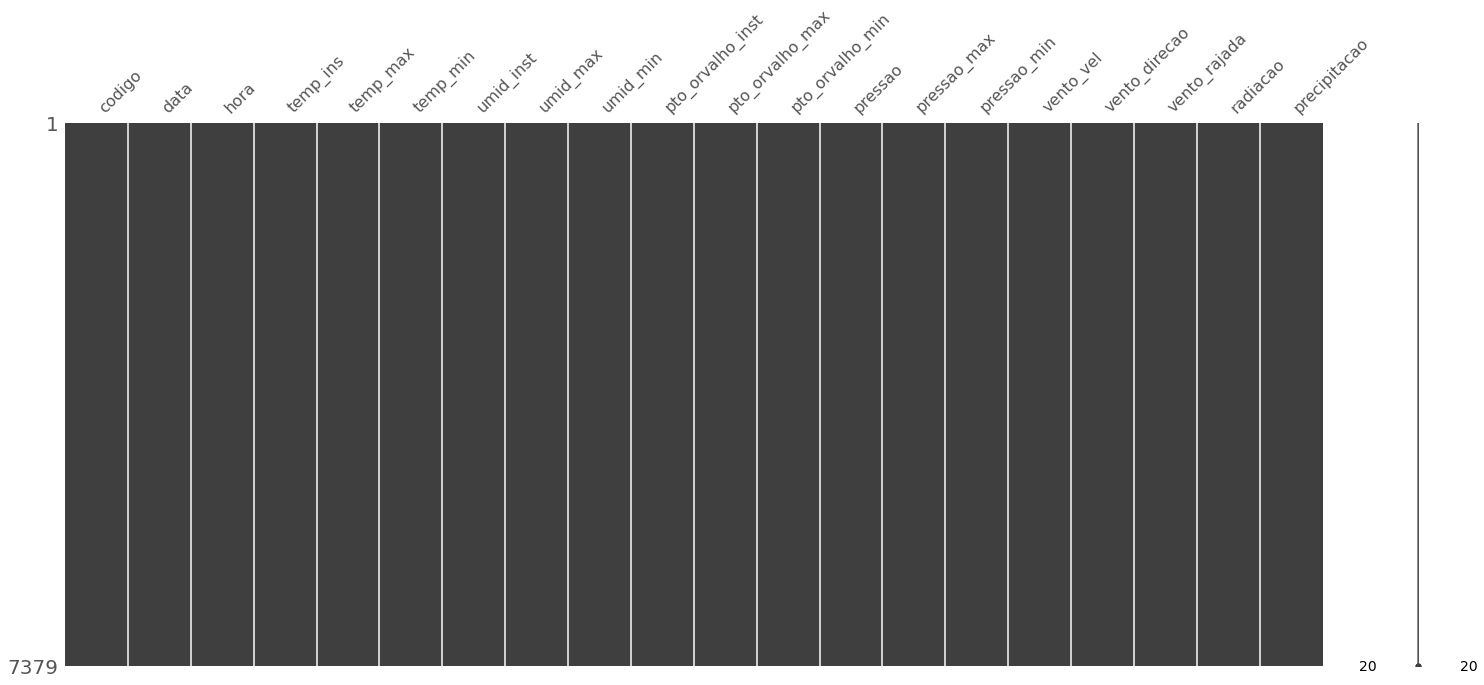

In [7]:
msno.matrix(portogrande) # com a matriz de nulidade vemos que os dados estao prontos para o processamento e modelagem

## Seleção de Features 

- Selecionando o nosso X e Y  

In [8]:
portogrande.columns

Index(['codigo', 'data', 'hora', 'temp_ins', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'vento_rajada', 'radiacao',
       'precipitacao'],
      dtype='object')

In [9]:
y = portogrande['precipitacao'] # precipitacao (volume de chuva)
X = portogrande.drop(['precipitacao','codigo','data','hora'], axis=1) # removendo chuva e algumas features 

- Separando em Treino e Teste

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=0)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape 

((5165, 16), (2214, 16), (5165,), (2214,))

# Modelagem 

In [42]:
k_vs_score = []
for k in range(2, Xtrain.shape[1], 2):
    selector_model = Lasso(alpha=1, normalize=True)
#     selector_model = LinearRegression(normalize=True)
#     selector_model = Ridge(alpha=0.1, normalize=True)
#     selector_model = RandomForestRegressor(random_state=1, n_jobs=-1)
    selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)

    selector.fit(Xtrain, ytrain)
    
    Xtrain2 = selector.transform(Xtrain)
    Xtest2 = selector.transform(Xtest)

    print(Xtrain.shape, Xtrain2.shape)
    
    mdl = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
#     mdl = XGBRegressor(objective="reg:squarederror", seed=0)
    mdl.fit(Xtrain2, ytrain)
    prev_chuva = mdl.predict(Xtest2)

    score = mean_absolute_error(ytest, prev_chuva)
    print("k = {} - MAE = {}".format(k, score))
    
    k_vs_score.append(score)

(5165, 16) (5165, 2)
k = 2 - MAE = 0.36075287971966646
(5165, 16) (5165, 4)
k = 4 - MAE = 0.2752806266078437
(5165, 16) (5165, 6)
k = 6 - MAE = 0.25787739741589333
(5165, 16) (5165, 8)
k = 8 - MAE = 0.25615685805336874
(5165, 16) (5165, 10)
k = 10 - MAE = 0.2561557362240289
(5165, 16) (5165, 12)
k = 12 - MAE = 0.2550380307136405
(5165, 16) (5165, 14)
k = 14 - MAE = 0.26390813008130076


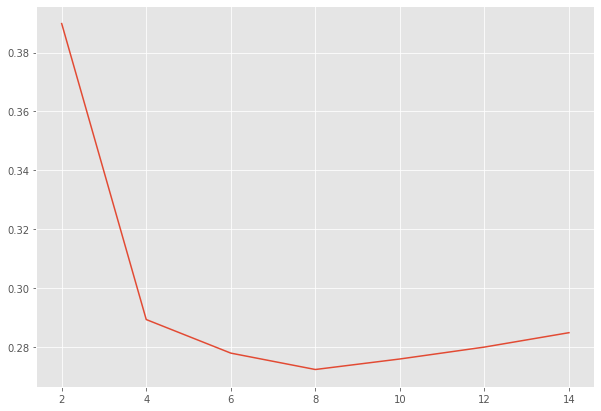

In [41]:
pd.Series(k_vs_score,index=range(2,X.shape[1],2)).plot(figsize=(10,7))

### Quais as features que o modelo selecionou?

- Todas as Features antes do loop

In [13]:
print(f'Total de features: {X.shape[1]}\n{X.columns}')

Total de features: 16
Index(['temp_ins', 'temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min',
       'pto_orvalho_inst', 'pto_orvalho_max', 'pto_orvalho_min', 'pressao',
       'pressao_max', 'pressao_min', 'vento_vel', 'vento_direcao',
       'vento_rajada', 'radiacao'],
      dtype='object')


- Depois do loop

In [14]:
mask = selector.get_support()
print(f'Total de Feature {len(Xtrain.columns[mask])}\n{Xtrain.columns[mask]}')

Total de Feature 14
Index(['temp_ins', 'temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min',
       'pto_orvalho_inst', 'pto_orvalho_max', 'pto_orvalho_min', 'pressao',
       'pressao_max', 'pressao_min', 'vento_vel', 'vento_direcao'],
      dtype='object')


### Conclusão:
- As feature que saiu foi Radiação e as anteriores que foram dropadas antes de treinar o modelo: data, hora, codigo_estacão

## Avaliando o desempenho do modelo

In [37]:
print(f'𝑅² - Coeficiente de determinação: {r2_score(ytest, prev_chuva).round(8)}') # 𝑅² quanto mais proximo de 1 melhor
print(f'MSE - Erro médio quadrático: {mean_squared_error(ytest, prev_chuva).round(8)}')# Mean Squared Error - mais proximo de 0 melhor
print(f'MAE - Mediana de erros de predição: {median_absolute_error(ytest, prev_chuva).round(8)}') # Median Absolute Error - menor melhor

𝑅² - Coeficiente de determinação: 0.57248943
MSE - Erro médio quadrático: 0.81988207
MAE - Mediana de erros de predição: 0.03053047


## Salvando as Previsões

In [16]:
resultado = pd.Series(prev_chuva)
resultado.to_csv('../output/prev_chuva_ptg.csv',index = False)